In [5]:
import numpy as np
%load_ext cython

In [2]:
xi1 = np.load('xi1.npy')

In [3]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
#flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [75]:
class LinearSpecialInterpolator:
    """
    LinearSpecialInterpolator(xi,x,y,z)
        
    A collection of methods to perform linear interpolation with direction correction,
    of three-dimensional strain eigenvectors.
        
    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
                 given at the grid points spanned by x, y and z
    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
    
    ******************************************************************************************
    
    Methods defined here:
    
    LinearSpecialInterpolator.__call__(x)
    
    Performs the aforementioned special linear interpolation of the eigenvector xi at
    the point x.
    
    param: x -- Three-component NumPy array, containing the coordinates at which a linear
                special interpolation of xi is sought; (x,y,z).
        
    return: Three-component NumPy array, containing the normalized linearly interpolated
            xi value at the point x.
    """
    def __init__(self,xi,x,y,z):
        self.xi = xi
        self.nx = xi.shape[0]
        self.ny = xi.shape[1]
        self.nz = xi.shape[2]
        self.dx = x[1]-x[0]
        self.dy = y[1]-y[0]
        self.dz = z[1]-z[0]
        self.x_min = x[0]
        self.x_max = x[-1]
        self.y_min = y[0]
        self.y_max = y[-1]
        self.z_min = z[0]
        self.z_max = z[-1]
        self.version = '0.1' # To keep track of changes as we go along
    
    def __call__(self,x):
        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
        cubevecs = [self.xi[ix,iy,iz],
                    self.xi[ixp1,iy,iz],
                    self.xi[ix,iyp1,iz],
                    self.xi[ixp1,iyp1,iz],
                    self.xi[ix,iy,izp1],
                    self.xi[ixp1,iy,izp1],
                    self.xi[ix,iyp1,izp1],
                    self.xi[ixp1,iyp1,izp1]]
        print(ix,iy,iz)
        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
        # an arbitrary reference point within the interpolation voxel
        for vec in cubevecs:
            if cubevecs[0].dot(vec) < 0:
                vec = -vec
        
        # 
        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
    
    def _compute_indices_and_weights(self,x,y,z):
        """
        param: x -- x-coordinate of the point at which a linear special interpolation of xi
                    is sought
        param: y -- y-coordinate of the point at which a linear special interpolation of xi
                    is sought
        param: z -- z-coordinate of the point at which a linear special interpolation of xi
                    is sought
                    
        return: x    -- Normalized relative coordinate within the interpolation voxel
        return: ix   -- Index indicating the corners of the interpolation voxel
        return: ixp1 -- Index indicating the corners of the interpolation voxel
        return: y    -- Normalized relative coordinate within the interpolation voxel
        return: iy   -- Index indicating the corners of the interpolation voxel
        return: iyp1 -- Index indicating the corners of the interpolation voxel
        return: z    -- Normalized relative coordinate within the interpolation voxel
        return: iz   -- Index indicating the corners of the interpolation voxel
        return: izp1 -- Index indicating the corners of the interpolation voxel
        """
        x = np.fmod((x-self.x_min)/self.dx,self.nx)
        y = np.fmod((y-self.y_min)/self.dy,self.nz)
        z = np.fmod((z-self.z_min)/self.dy,self.nz)
        
        while x < 0:
            x += self.nx
        while y < 0:
            y += self.ny
        while z < 0:
            z += self.nz
            
        ix = np.floor(x).astype(int)
        iy = np.floor(y).astype(int)
        iz = np.floor(z).astype(int)
        
        x -= ix
        y -= iy
        z -= iz
        
        ixp1 = int((ix+1)%self.nx)
        iyp1 = int((iy+1)%self.ny)
        izp1 = int((iz+1)%self.nz)
        
        return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
    
    @staticmethod
    def _normalized_weighted_sum(cubevecs,x,y,z):
        """
        param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
        param:        x -- Normalized relative coordinate within the interpolation voxel
        param:        y -- Normalized relative coordinate within the interpolation voxel
        param:        z -- Normalized relative coordinate within the interpolation voxel
        
        return:     vec -- Normalized linearly interpolated xi vector 
        """
        vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
                +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
        return vec/np.linalg.norm(vec)

In [91]:
%%cython

cimport cython
cimport numpy as np
import numpy as np

from libc.math cimport fmod as c_fmod,\
                       floor as c_floor,\
                       sqrt as c_sqrt
    
from scipy.linalg.cython_blas cimport ddot as cy_ddot

cdef class CyLinSpecInterp:
    cdef:
        double[:,:,:,::1] xi
        int nx, ny, nz
        double dx, dy, dz
        double x_min, x_max
        double y_min, y_max
        double z_min, z_max
        
    @cython.initializedcheck(False)
    @cython.wraparound(False)
    def __cinit__(self, double[:,:,:,::1] xi, double[::1] x, double[::1] y, double[::1] z):
        self.xi = xi
        self.nx = x.shape[0]
        self.ny = y.shape[0]
        self.nz = z.shape[0]
        self.dx = x[1]-x[0]
        self.dy = y[1]-y[0]
        self.dz = z[1]-z[0]
        self.x_min = x[0]
        self.x_max = x[self.nx-1]
        self.y_min = y[0]
        self.y_max = y[self.ny-1]
        self.z_min = z[0]
        self.z_max = z[self.nz-1]
        
    def __call__(self, double[::1] pos):
        cdef:
            double x = pos[0], y = pos[1], z = pos[2]
            int ix, iy, iz, ixp1, iyp1, izp1
            double cubevecs[8][3]
            double[:,::1] cv
            int i, j
            double vec[3]
            
        self._compute_indices_and_weights(&x, &y, &z, &ix, &iy, &iz, &ixp1, &iyp1, &izp1)
        
        print(ix,iy,iz)
        
        for i in range(3):
            cubevecs[0][i] = self.xi[ix,iy,iz,i]
            cubevecs[1][i] = self.xi[ixp1,iy,iz,i]
            cubevecs[2][i] = self.xi[ix,iyp1,iz,i]
            cubevecs[3][i] = self.xi[ixp1,iyp1,iz,i]
            cubevecs[4][i] = self.xi[ix,iy,izp1,i]
            cubevecs[5][i] = self.xi[ixp1,iy,izp1,i]
            cubevecs[6][i] = self.xi[ix,iyp1,izp1,i]
            cubevecs[7][i] = self.xi[ixp1,iyp1,izp1,i]
        
        v1 = cubevecs[i]
        for i in range(8):
            if self._blas_dotproduct_(cubevecs[i], cubevecs[0]) < 0:
                for j in range(3):
                    cubevecs[i][j] = -cubevecs[i][j]
            
        cv = cubevecs
        self._normalized_weighted_sum(cv, x, y, z, &vec[0])
        return np.asarray(vec)
        
    @cython.initializedcheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_indices_and_weights(self, double *x, double *y, double *z,
                                            int *ix, int *iy, int *iz,
                                            int *ixp1, int *iyp1, int *izp1):
        x[0] = c_fmod((x[0]-self.x_min)/self.dx,self.nx)
        y[0] = c_fmod((y[0]-self.y_min)/self.dy,self.nz)
        z[0] = c_fmod((z[0]-self.z_min)/self.dy,self.nz)
        while x[0] < 0:
            x[0] += self.nx
        while y[0] < 0:
            y[0] += self.ny
        while z[0] < 0:
            z[0] += self.nz
            
        ix[0] = int(c_floor(x[0]))
        iy[0] = int(c_floor(y[0]))
        iz[0] = int(c_floor(z[0]))
        
        x[0] -= ix[0]
        y[0] -= iy[0]
        z[0] -= iz[0]
        
        ixp1[0] = int((ix[0]+1)%self.nx)
        iyp1[0] = int((iy[0]+1)%self.ny)
        izp1[0] = int((iz[0]+1)%self.nz)
    
    cdef double _blas_dotproduct_(self,double *x, double *y):
        cdef:
            int N = 3
            int INCX = 1, INCY = 1
        
        return cy_ddot(&N, &x[0], &INCX, &y[0], &INCY)
    
    @cython.initializedcheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _normalized_weighted_sum(self,double[:,::1] cubevecs, double x,double y,double z, double *vec):
        cdef:
            long i
            double nrm
        for i in range(3):
            vec[i] = ((cubevecs[0,i]*(1-x)+cubevecs[1,i]*x)*(1-y) + (cubevecs[2,i]*(1-x)+cubevecs[3,i]*x)*y)*(1-z)\
                    +((cubevecs[4,i]*(1-x)+cubevecs[5,i]*x)*(1-y) + (cubevecs[6,i]*(1-x)+cubevecs[7,i]*x)*y)*z
        
        nrm = c_sqrt(self._blas_dotproduct_(vec,vec))
        for i in range(3):
            vec[i] /= nrm

In [92]:
foo = LinearSpecialInterpolator(xi1,x,y,z)

In [93]:
bar = CyLinSpecInterp(xi1,x,y,z)

In [94]:
foo(pos)

1 1 1


array([-0.64777056,  0.2446508 ,  0.72148409])

In [95]:
bar(pos)

1 1 1


array([-0.64777056,  0.2446508 ,  0.72148409])

In [70]:
dz

0.06159985595274104

In [96]:
xi1[2,2,2]

array([-0.58229712,  0.37665909,  0.7204568 ])

In [57]:
pos = np.array([0.12,0.12,0.12])

In [37]:
%timeit foo(pos)

81.4 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [39]:
%timeit bar(pos)

4.14 µs ± 37.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [58]:
foo(pos)

array([-0.64777056,  0.2446508 ,  0.72148409])

In [59]:
bar(pos)

array([-0.57735027,  0.70710678, -0.40824829])

In [50]:
%timeit foo(pos)

81.3 µs ± 4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [52]:
%timeit bar(pos)

5.33 µs ± 92.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [53]:
a = bar(pos)

In [54]:
np.linalg.norm(a)

1.0

In [56]:
y

array([0.        , 0.06220976, 0.12441951, 0.18662927, 0.24883902,
       0.31104878, 0.37325853, 0.43546829, 0.49767804, 0.5598878 ,
       0.62209756, 0.68430731, 0.74651707, 0.80872682, 0.87093658,
       0.93314633, 0.99535609, 1.05756584, 1.1197756 , 1.18198535,
       1.24419511, 1.30640487, 1.36861462, 1.43082438, 1.49303413,
       1.55524389, 1.61745364, 1.6796634 , 1.74187315, 1.80408291,
       1.86629267, 1.92850242, 1.99071218, 2.05292193, 2.11513169,
       2.17734144, 2.2395512 , 2.30176095, 2.36397071, 2.42618047,
       2.48839022, 2.55059998, 2.61280973, 2.67501949, 2.73722924,
       2.799439  , 2.86164875, 2.92385851, 2.98606826, 3.04827802,
       3.11048778, 3.17269753, 3.23490729, 3.29711704, 3.3593268 ,
       3.42153655, 3.48374631, 3.54595606, 3.60816582, 3.67037558,
       3.73258533, 3.79479509, 3.85700484, 3.9192146 , 3.98142435,
       4.04363411, 4.10584386, 4.16805362, 4.23026338, 4.29247313,
       4.35468289, 4.41689264, 4.4791024 , 4.54131215, 4.60352

In [61]:
xi1[2,2,2]

array([-0.58229712,  0.37665909,  0.7204568 ])

In [62]:
xi1.shape

(101, 102, 103, 3)

In [101]:
x1 = np.linspace(0,2,40)
y1 = np.sin(np.pi*x1)

In [102]:
from matplotlib import pyplot as plt

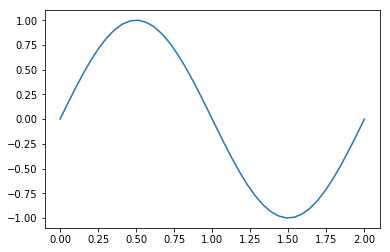

In [103]:
plt.plot(x1,y1)

In [104]:
ind = 27
inds = [ind-1, ind, ind+1, ind+2]

In [130]:
def func(t):
    larr = np.array([t**3,t**2,t,1])
    fac = 1/6
    mat1 = np.array([[-1,3,-3,1],[3,-6,3,0],[-3,0,3,0],[1,4,1,0]])
    rvc = np.array([x1[inds],y1[inds]]).T
    return larr.dot(fac*mat1.dot(rvc))

In [131]:
func(1)

array([ 1.43589744, -0.97556131])

In [132]:
ts = np.linspace(0,1,100)
xs2, ys2 = func(ts)

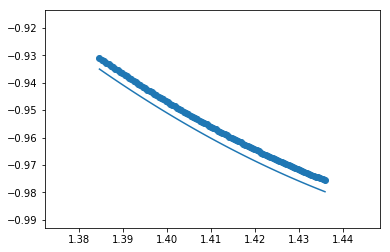

In [135]:
plt.scatter(xs2,ys2)
plt.plot(xs2,np.sin(np.pi*xs2))

In [138]:
np.sqrt((x1[1]-x1[0])*np.sum((ys2-np.sin(np.pi*xs2))**2))

0.009381727477013648